# Прогнозирование заказов такси

## Введение

Закзачик: Компания «Чётенькое такси»

Компании нужен прогноз заказов на следующий час, чтобы привлекать больше водителей в часы пиковой нагрузки. Для прогнозириования компания предоставила исторические данные о заказах такси в аэропортах.

### Цель проекта

Целью проекта является прогонозирование количества заказов такси в аэропортах на следующий час.

### Основные этапы

В проекте мы выполнили следующие этапы:
- загрузили и проанализировали предоставленные данные;
- подготовили данные для пронозирования;
- обучили две модели и сравнили их качество;
- проверили данные на тестовой выборке.

### Выводы

## Подготовка кода

### Загрузка библиотек

In [1]:
import pandas as pd
from os import path

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_validate, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, SplineTransformer

from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

from sklearn.kernel_approximation import Nystroem

from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import RidgeCV

In [4]:
import numpy as np 

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

### Функции

In [6]:
RANDOM_STATE = np.random.RandomState(275647)

#### exponential_smoothing

In [7]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]]  # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n - 1])
    return result

#### plotMovingAverage

In [8]:
def plotMovingAverage(
    series, window, plot_intervals=False, scale=1.96, plot_anomalies=False
):

    """
        series - dataframe with timeseries
        window - rolling window size
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15, 5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", lw=2, label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", alpha=.25, label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--", alpha=.25)

        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series < lower_bond] = series[series < lower_bond]
            anomalies[series > upper_bond] = series[series > upper_bond]
            plt.plot(anomalies, "ro", markersize=5)

    plt.plot(series[window:], alpha=.5, lw=.5, label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

#### plotExpSmoothing

In [9]:
def plotExpSmoothing(
    series, alpha, plot_intervals=False, scale=1.96, plot_anomalies=False
):

    """
        series - dataframe with timeseries
        alpha - smoothing parameter
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies

    """
    exp_smoothing = pd.DataFrame(exponential_smoothing(series.num_orders, alpha), 
                                 index=series.index, columns=series.columns)

    plt.figure(figsize=(15, 5))
    plt.title("Exponential Smoothing\n alpha = {}".format(alpha))
    plt.plot(exp_smoothing, "g", lw=2, label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series, exp_smoothing)
        deviation = np.std(series - exp_smoothing)
        lower_bond = exp_smoothing - (mae + scale * deviation)
        upper_bond = exp_smoothing + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", alpha=.25, label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--", alpha=.25)

        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series < lower_bond] = series[series < lower_bond]
            anomalies[series > upper_bond] = series[series > upper_bond]
            plt.plot(anomalies, "ro", markersize=5)

    plt.plot(series, alpha=.5, lw=.5, label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

####  make_window

In [10]:
def make_window(ts, resample_frame, date_part_func):
    _df = (ts
           .resample(resample_frame)
           .sum()
           .assign(date_part = date_part_func)
           .pivot_table(
               index="date_part",
               values="num_orders",
               aggfunc=[np.mean, np.std])
          )
    _df.columns = ["num_orders_mean", "num_orders_std"]
    return _df

#### draw_window

In [11]:
def draw_window(ts, resample_frame, date_part_func, ax, xlabel, title):
    _df = make_window(ts, resample_frame, date_part_func)
    ax.plot(_df.index, _df.num_orders_mean, lw=3, label="mean")
    ax.fill_between(_df.index,
                     _df.num_orders_mean - _df.num_orders_std,
                     _df.num_orders_mean + _df.num_orders_std,
                     alpha=.1, 
                     label="std")
    ax.set_title(title.upper())
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Количество заказов")
    ax.legend().set_visible(True)

#### prepare_data

In [12]:
def prepare_data(data, lag_start, lag_end, test_size):
    """
        series: pd.DataFrame
            dataframe with timeseries

        lag_start: int
            initial step back in time to slice target variable
            example - lag_start = 1 means that the model
                      will see yesterday's values to predict today

        lag_end: int
            final step back in time to slice target variable
            example - lag_end = 4 means that the model
                      will see up to 4 days back in time to predict today

        test_size: float
            size of the test dataset after train/test split as percentage of dataset

        target_encoding: boolean
            if True - add target averages to the dataset

    """

    data.columns = ["y"]
    
    # lags of series
    for i in range(lag_start, lag_end):
        data[f"lag_{i}"] = data.y.shift(i)

    # datetime features
    data["hour"] = data.index.hour
    data["weekday"] = data.index.weekday
    data["weeknum"] = data.index.isocalendar().week


    # train-test split
    y = data.dropna().y
    X = data.dropna().drop(["y"], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, shuffle=False
    )

    return X_train, X_test, y_train, y_test

#### print_best_params

In [13]:
def print_best_params(best_params: dict) -> None:
    space = max([len(_) for _ in best_params.keys()])
    print("Best params:")
    for k, v in best_params.items():
        print(f'{k+" "*(space-len(k))}  {v}')
    print()

#### evaluate

In [14]:
def evaluate(model, X, y, cv, params_distribution=None):
    scoring = ["neg_mean_absolute_error", "neg_root_mean_squared_error", "r2"]
    fitted_model = None
    
    if params_distribution is None:
        cv_results = cross_validate(
            model,
            X,
            y,
            cv=cv,
            scoring=scoring,
        )
        mae = -cv_results["test_neg_mean_absolute_error"].mean()
        mae_std = -cv_results["test_neg_mean_absolute_error"].std()

        rmse = -cv_results["test_neg_root_mean_squared_error"].mean()
        rmse_std = -cv_results["test_neg_root_mean_squared_error"].std()

        r2 = cv_results["test_r2"].mean()
        r2_std = cv_results["test_r2"].std()
        
        fitted_model = model.fit(X, y)
    else:
        cv_results_cols = [ _ for col in scoring for _ in [f"mean_test_{col}", f"std_test_{col}"] ]
        search_cv = RandomizedSearchCV(
            estimator=model,
            param_distributions=gbrt_param_distributions,
            n_iter=50,
            n_jobs=-1,
            refit="neg_mean_absolute_error",
            cv=ts_cv,
            scoring=scoring,
            verbose=1,
            random_state=RANDOM_STATE,
            return_train_score=True)
        search_cv.fit(X, y)
        
        cv_results = pd.DataFrame(search_cv.cv_results_)[cv_results_cols]
        best_idx = cv_results.mean_test_neg_mean_absolute_error.idxmax()
        
        mae = -cv_results.mean_test_neg_mean_absolute_error[best_idx]
        mae_std = -cv_results.std_test_neg_mean_absolute_error[best_idx]
        
        rmse = -cv_results.mean_test_neg_root_mean_squared_error[best_idx]
        rmse_std = -cv_results.std_test_neg_root_mean_squared_error[best_idx]
        
        r2 = cv_results.mean_test_r2[best_idx]
        r2_std = cv_results.std_test_r2[best_idx]

        print_best_params(search_cv.best_params_)
        fitted_model = search_cv.best_estimator_
        
    print(
        f"Mean Absolute Error:     {mae:.3f} +/- {mae_std:.3f}\n"
        f"Root Mean Squared Error: {rmse:.3f} +/- {rmse_std:.3f}\n"
        f"R2 Score:                {r2:.3f} +/- {r2_std:.3f}"
    )
    
    return fitted_model

#### periodic_spline_transformer

In [15]:
def periodic_spline_transformer(period, n_splines=None, degree=3):
    if n_splines is None:
        n_splines = period
    n_knots = n_splines + 1  # periodic and include_bias is True
    return SplineTransformer(
        degree=degree,
        n_knots=n_knots,
        knots=np.linspace(0, period, n_knots).reshape(n_knots, 1),
        extrapolation="periodic",
        include_bias=True,
    )

#### visualize_predictions

In [62]:
def visualize_predictions(models, model_names, X, y, stage="Train"):
    fig, axes = plt.subplots(2, 2, figsize=(12,10))
    for m, l , ax in zip(models, model_names, axes.ravel()):

        y_hat = m.predict(X)
        mae = mean_absolute_error(y, y_hat)
        ax.plot(y.index, y_hat, lw=3, label="prediction")
        ax.plot(y.index, y_train[-term:], lw=3, label="actual")
        ax.set_title(f"{l} on train data\nmae={mae:.2f}")
        ax.set_xticks(ticks=y.index, labels=y.index.hour)
        for label in ax.xaxis.get_ticklabels():
            if int(label.get_text()) % 4 != 0:
                label.set_visible(False)
                
        ax.set_xlabel("часы")
        ax.set_ylabel("Количество заказов")
        ax.legend()
    plt.tight_layout()
    plt.show()

### Инициализация

## Загрузка и анализ данных

In [16]:
remote_path = 'https://code.s3.yandex.net/datasets/taxi.csv'
local_path = path.join('.', 'data', 'taxi.csv')

if path.isfile(local_path):
    data = pd.read_csv(local_path, index_col=0, parse_dates=[0])
else:
    data = pd.read_csv(remote_path, index_col=0, parse_dates=[0])
    if path.exists(path.dirname(local_path)):
        data.to_csv(local_path)
        
data.shape

(26496, 1)

Загрузили 26496 строк данных с одним признаком.

### Анализ данных

#### Обзорный анализ

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


В данных видим количество заказов `num_orders`, целочисленное, без пропусков. 

Диапазон времени от 0 часов 0 минут 1 марта 2018 до 23:50 31 августа 2018 года. Имеем данные за шесть месяцев.

In [18]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


В первых строчках видим 10-минутные интервалы между записями.

Проверим, что индекс монотонно возрастает.

In [19]:
data.index.is_monotonic_increasing

True

Проверим, что интервалы одинаковые и равны 10 минутам.

In [20]:
dt = data.reset_index().drop("num_orders", axis=1)
(dt["datetime"] - dt["datetime"].shift()).describe()

count              26495
mean     0 days 00:10:00
std      0 days 00:00:00
min      0 days 00:10:00
25%      0 days 00:10:00
50%      0 days 00:10:00
75%      0 days 00:10:00
max      0 days 00:10:00
Name: datetime, dtype: object

In [21]:
del(dt)

Инервалы одинаковые и равны 10 минутам.

Изучим распределение количества заказов.

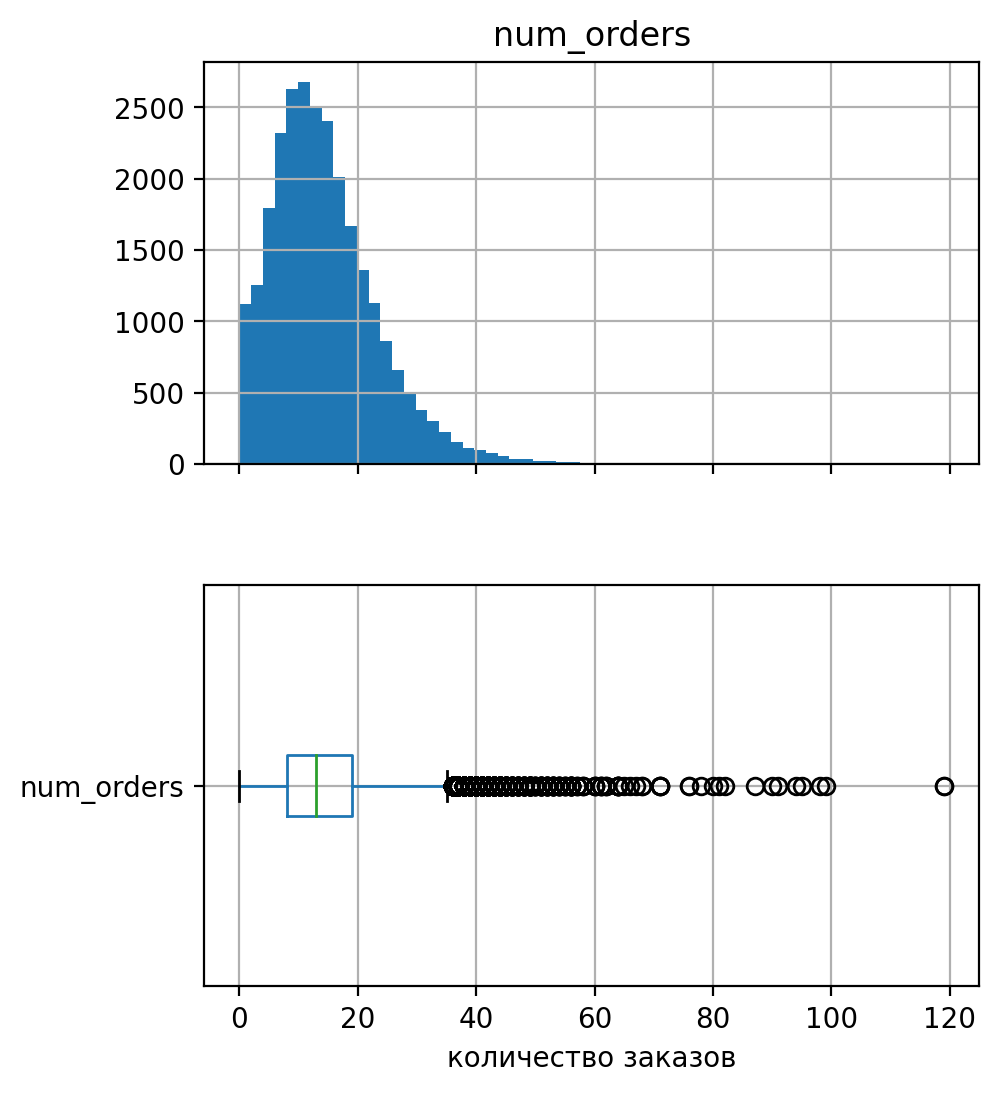

In [22]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(5, 6), sharex=True)
data.hist(bins=60, ax=ax1)
data.boxplot(ax=ax2, vert=False)
ax2.set_xlabel("количество заказов")
plt.show()

In [23]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Распределение количества заказов близко к нормальному, смещено влево. 

В половине случаев количество заказов за 10 минут находится в интервале 8–19. Однако есть и вылеты с количеством заказов больше 35. Действительно видим пиковые периоды, когда количество заказов существенно выше среднего.

#### Анализ временного ряда

Поскольку перед нами стоит задача спрогнозировать количество заказов в следующий час, выполним ресемплирование данных по 1 часу.

In [24]:
data = data.resample("1H").sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [25]:
data.shape

(4416, 1)

Для анализа возьмем возьмем первые 90% данных, чтобы не заглядывать в тестовую выборку.

In [26]:
eda_df, _ = train_test_split(data, train_size=.9, shuffle=False)
eda_df.shape

(3974, 1)

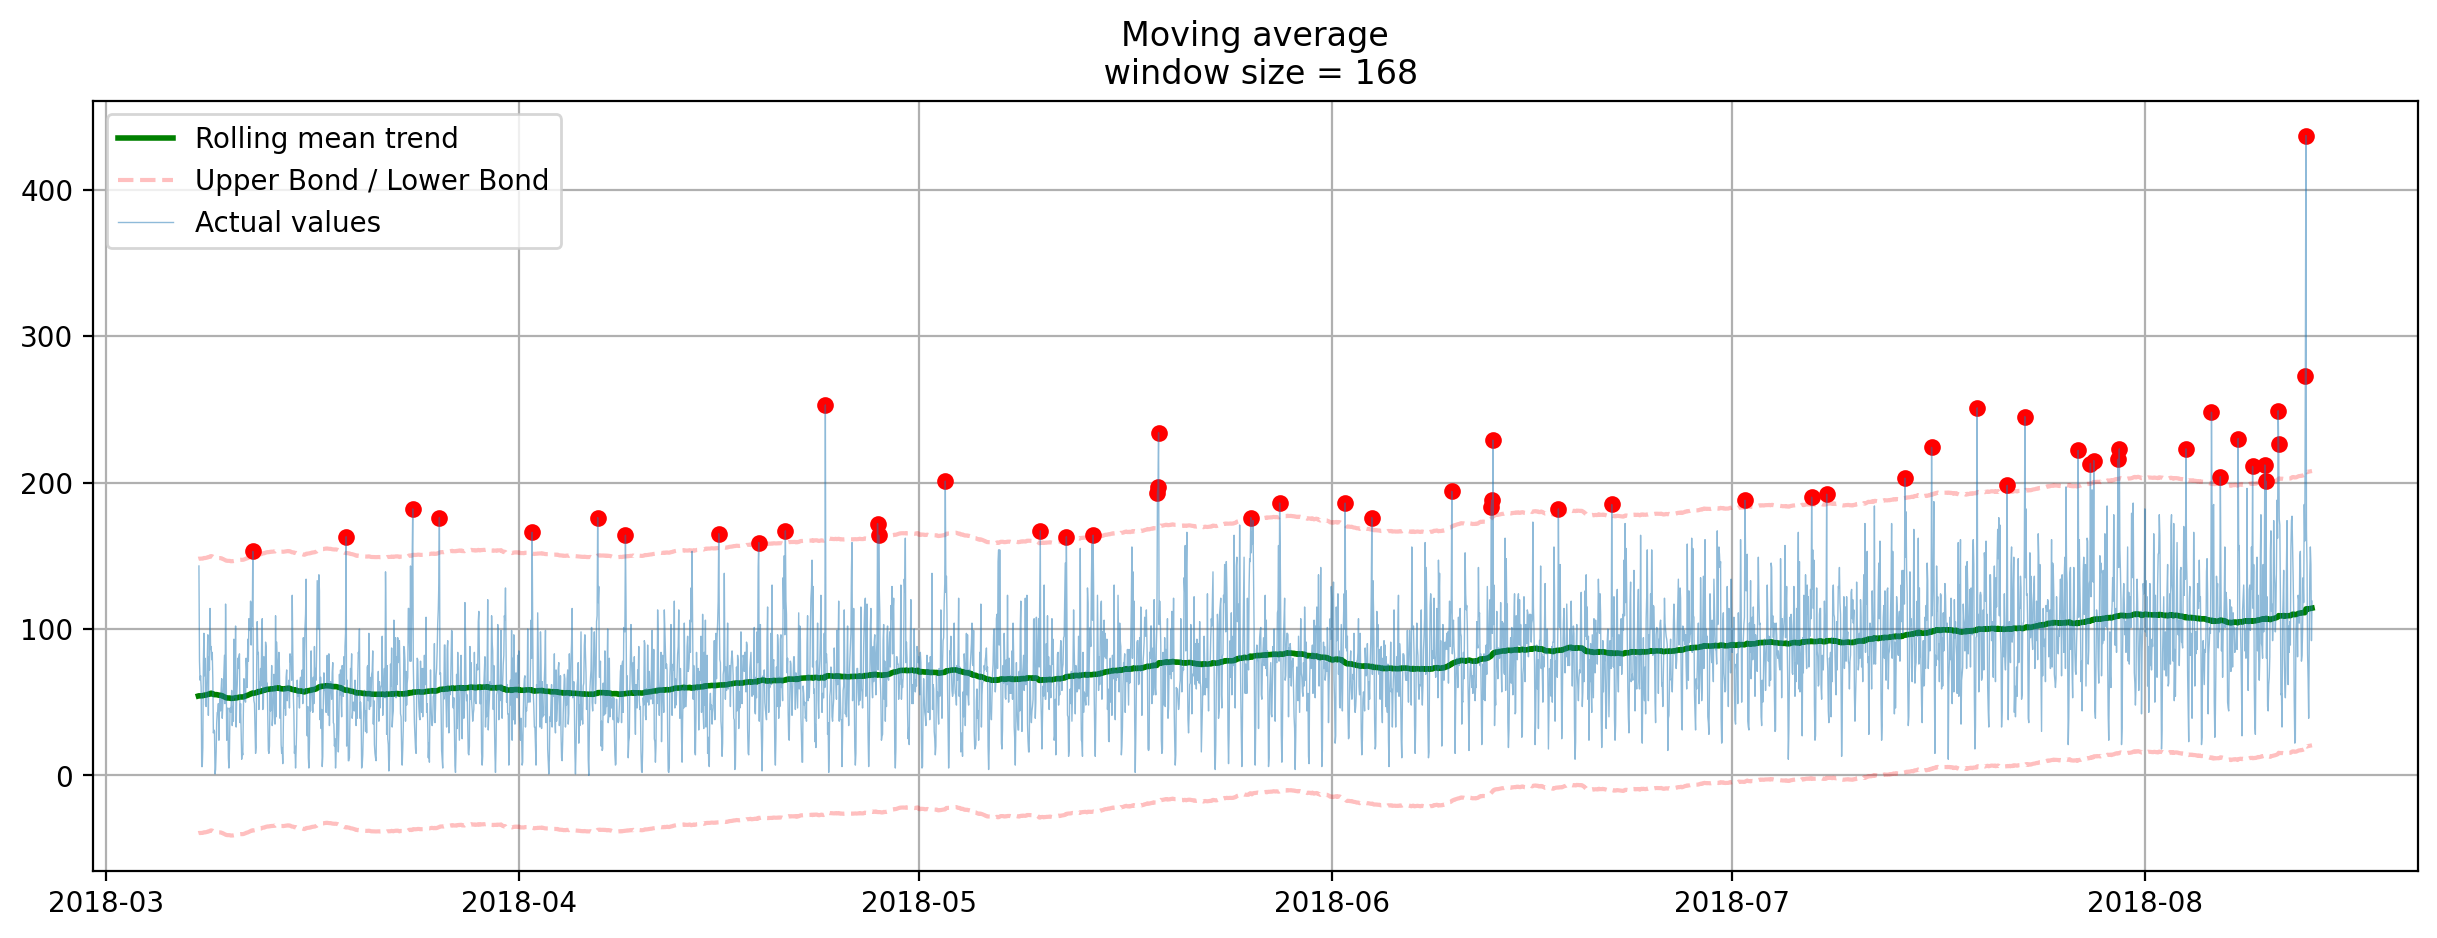

In [27]:
plotMovingAverage(
    eda_df, 24*7, plot_intervals=True, plot_anomalies=True
)  

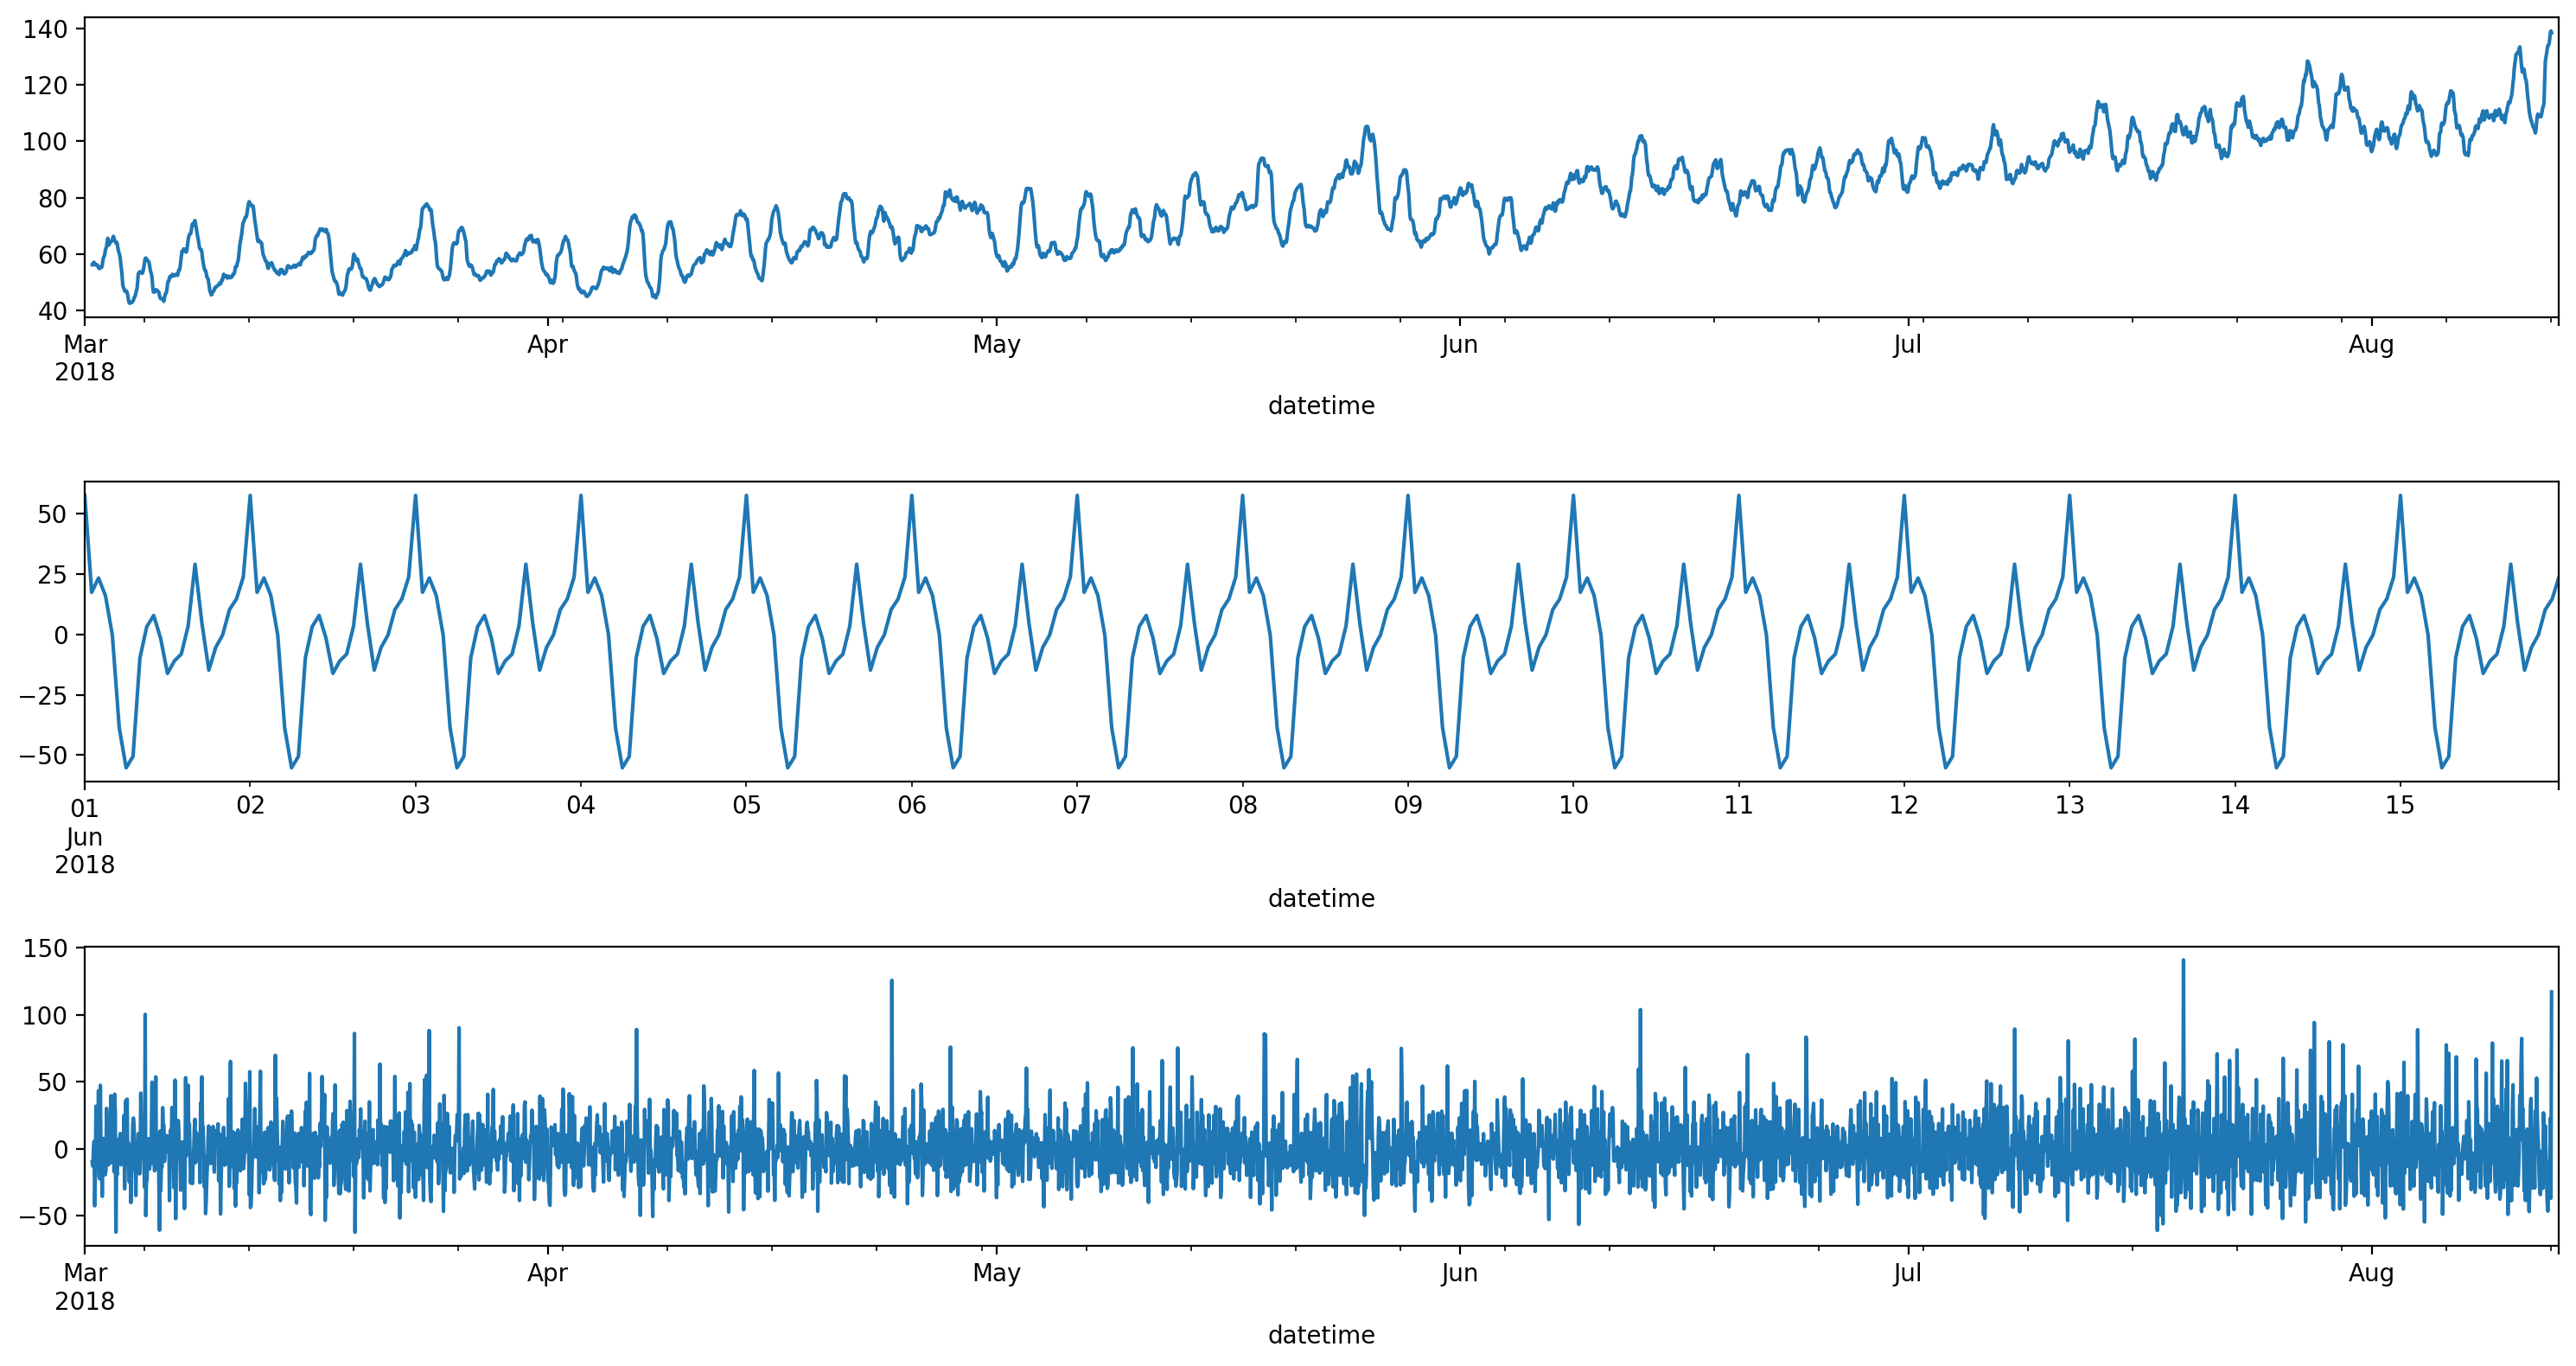

In [28]:
decomposed = seasonal_decompose(eda_df)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 8), sharex=False)
decomposed.trend.plot(ax=ax1)
decomposed.seasonal["2018-06-01":"2018-06-15"].plot(ax=ax2)
decomposed.resid.plot(ax=ax3)
plt.tight_layout()
plt.show()

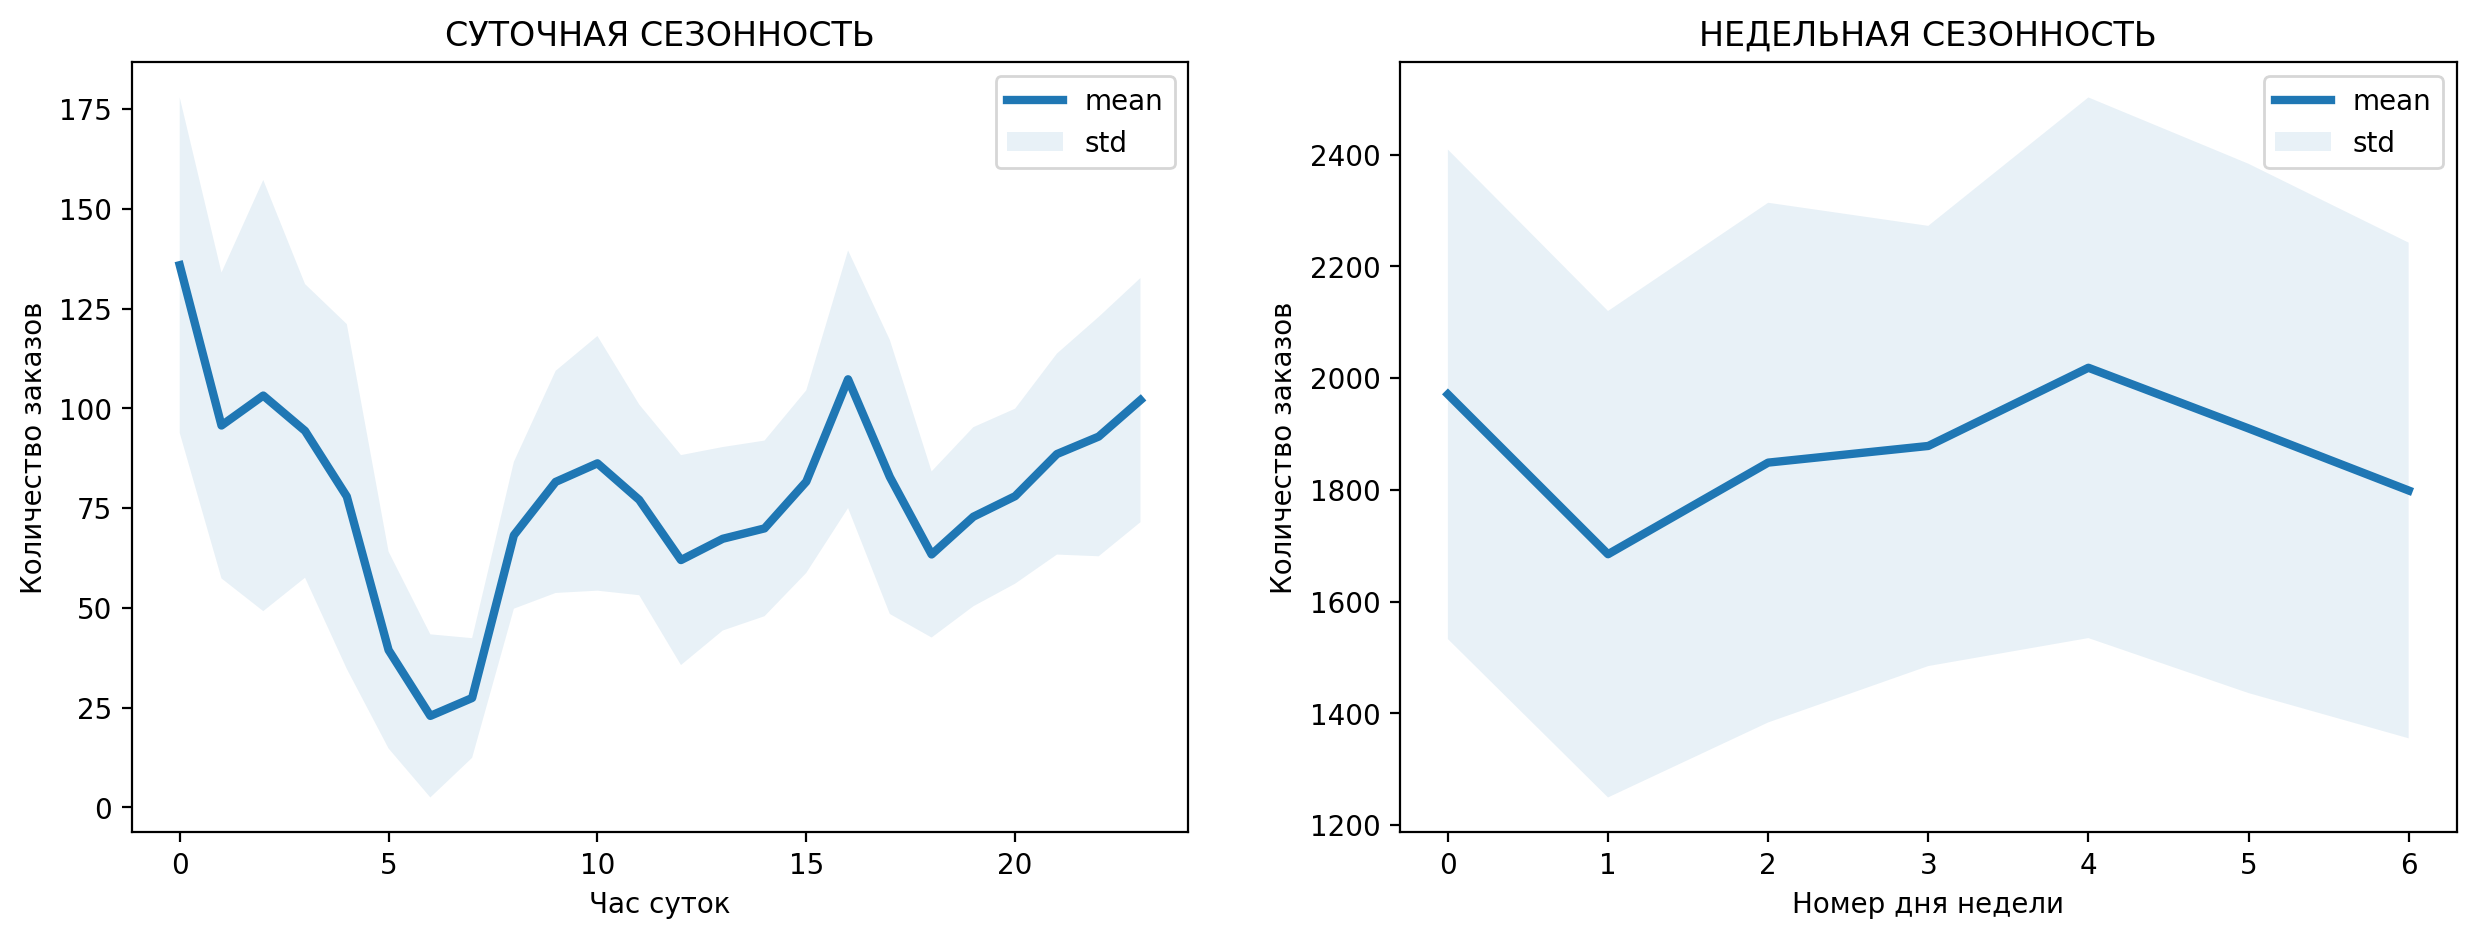

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
draw_window(ts=eda_df, 
            resample_frame="1H", 
            date_part_func = lambda x: x.index.hour,
            ax=ax1, 
            xlabel="Час суток", 
            title="Суточная сезонность")
draw_window(ts=eda_df, 
            resample_frame="1D", 
            date_part_func = lambda x: x.index.weekday,
            ax=ax2, 
            xlabel="Номер дня недели", 
            title="Недельная сезонность")


plt.show()

### Вывод

## Подготовка данных

### Создание признаков

Поскольку мы видим суточную и недельную сезонность, а также возрастающий тренд, создадим признаки:
- час суток
- номер дня недели
- лаг за 4, 5, 6 часов от текущего

In [30]:
X_train, X_test, y_train, y_test = prepare_data(data.copy(), 4, 7, .1)

In [31]:
X_train.shape, y_train.shape

((3969, 6), (3969,))

In [32]:
X_test.shape, y_test.shape

((441, 6), (441,))

In [33]:
y_train.index[0], y_train.index[-1]

(Timestamp('2018-03-01 06:00:00', freq='H'),
 Timestamp('2018-08-13 14:00:00', freq='H'))

In [34]:
y_test.index[0], y_test.index[-1]

(Timestamp('2018-08-13 15:00:00', freq='H'),
 Timestamp('2018-08-31 23:00:00', freq='H'))

In [35]:
categorical_columns = X_train.columns.to_list()[-2:]
categorical_columns

['weekday', 'weeknum']

We will use a time-sensitive cross-validation splitter to evaluate our demand forecasting model as realistically as possible. 

In [36]:
ts_cv = TimeSeriesSplit(
    n_splits=5
)

## Обучение моделей

In [37]:
one_hot_encoder = OneHotEncoder(handle_unknown="ignore")
alphas = np.logspace(-6, 6, 10)
naive_linear_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("categorical", one_hot_encoder, categorical_columns),
        ],
        remainder=MinMaxScaler(),
    ),
    RidgeCV(alphas=alphas),
)

In [38]:
naive_linear_model = evaluate(naive_linear_pipeline, X_train, y_train, cv=ts_cv)

Mean Absolute Error:     31.095 +/- -6.971
Root Mean Squared Error: 40.539 +/- -8.771
R2 Score:                -0.320 +/- 0.267


In [39]:
cyclic_spline_transformer = ColumnTransformer(
    transformers=[
        ("cyclic_weekday", periodic_spline_transformer(7, n_splines=7), ["weekday"]),
        ("cyclic_hour", periodic_spline_transformer(24, n_splines=24), ["hour"]),
    ],
    remainder=MinMaxScaler(),
)
cyclic_spline_linear_pipeline = make_pipeline(
    cyclic_spline_transformer,
    RidgeCV(alphas=alphas),
)
cyclic_spline_linear_model = evaluate(cyclic_spline_linear_pipeline, X_train, y_train, cv=ts_cv)

Mean Absolute Error:     19.456 +/- -2.362
Root Mean Squared Error: 25.980 +/- -3.622
R2 Score:                0.454 +/- 0.022


In [40]:
gbrt_pipeline = make_pipeline(
    cyclic_spline_transformer,
    HistGradientBoostingRegressor(random_state=RANDOM_STATE)
)
gbrt_default_model = evaluate(gbrt_pipeline, X_train, y_train, cv=ts_cv)

Mean Absolute Error:     17.803 +/- -1.583
Root Mean Squared Error: 24.097 +/- -2.855
R2 Score:                0.526 +/- 0.056


In [41]:
gbrt_param_distributions = {
    "histgradientboostingregressor__max_iter":
        np.arange(50, 500, 50),
    "histgradientboostingregressor__learning_rate":
        np.logspace(-2, 1, num=10, endpoint=True, base=10, dtype=float, axis=0),
    "histgradientboostingregressor__min_samples_leaf": 
        [2**i for i in range(4, 6)],
    "histgradientboostingregressor__l2_regularization": alphas    
}

In [42]:
%%time
gbrt_tuned_model = evaluate(gbrt_pipeline,
         X_train,
         y_train,
         cv=ts_cv,
         params_distribution=gbrt_param_distributions)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best params:
histgradientboostingregressor__min_samples_leaf   8
histgradientboostingregressor__max_iter           150
histgradientboostingregressor__learning_rate      0.021544346900318832
histgradientboostingregressor__l2_regularization  0.01

Mean Absolute Error:     17.900 +/- -2.128
Root Mean Squared Error: 24.494 +/- -3.467
R2 Score:                0.513 +/- 0.048
CPU times: user 3.55 s, sys: 368 ms, total: 3.92 s
Wall time: 1min 1s


In [54]:
models = [
            naive_linear_model, cyclic_spline_linear_model, gbrt_default_model,
            gbrt_tuned_model
        ]
model_names = [
            "naive_linear_model", "cyclic_spline_linear_model",
            "gbrt_default_model", "gbrt_tuned_model"
        ]

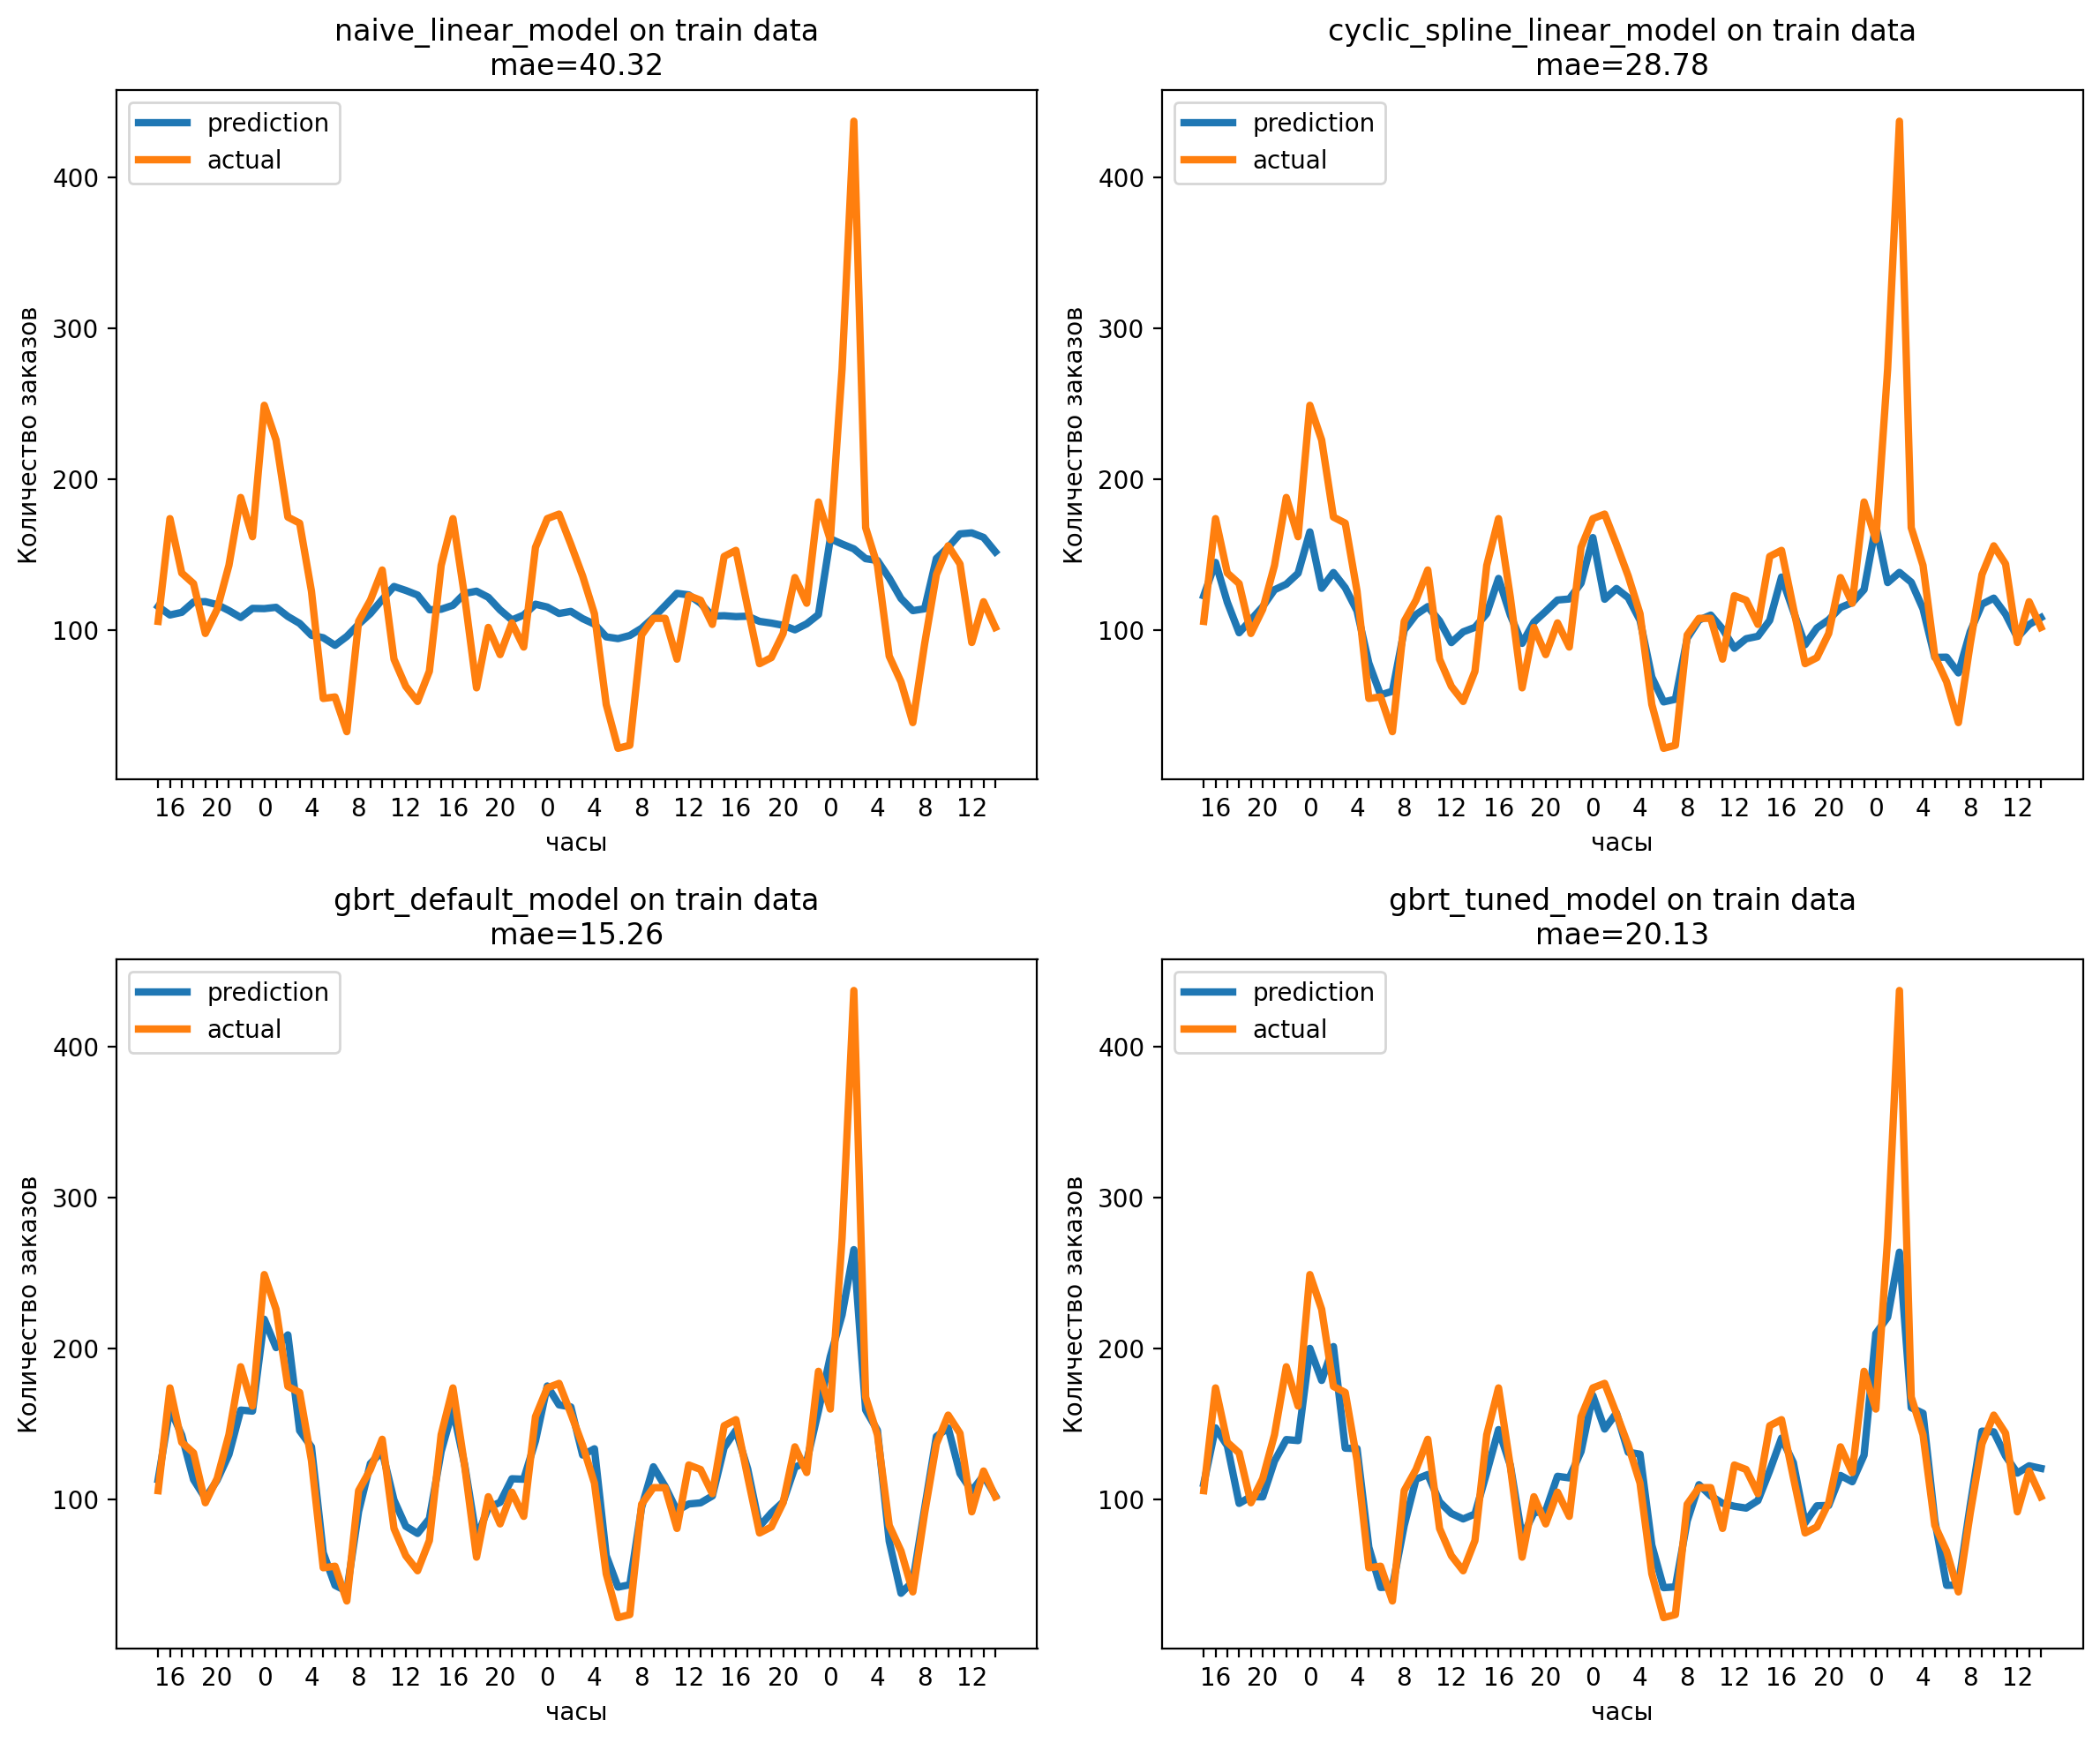

In [63]:
term = 72
visualize_predictions(models=models,
                      model_names=model_names,
                      X = X_train[-term:],
                      y = y_train[-term:],
                      stage="Train")

## Тестирование

In [70]:
name_len = max(len(_) for _ in model_names)
for m, l in zip(models, model_names):
    y_hat = m.predict(X_test)
    mae = mean_absolute_error(y_test, y_hat)
    print(f"{l} {' ' * (name_len - len(l))} MAE {mae:.2f}")

naive_linear_model          MAE 70.04
cyclic_spline_linear_model  MAE 36.92
gbrt_default_model          MAE 34.11
gbrt_tuned_model            MAE 29.03


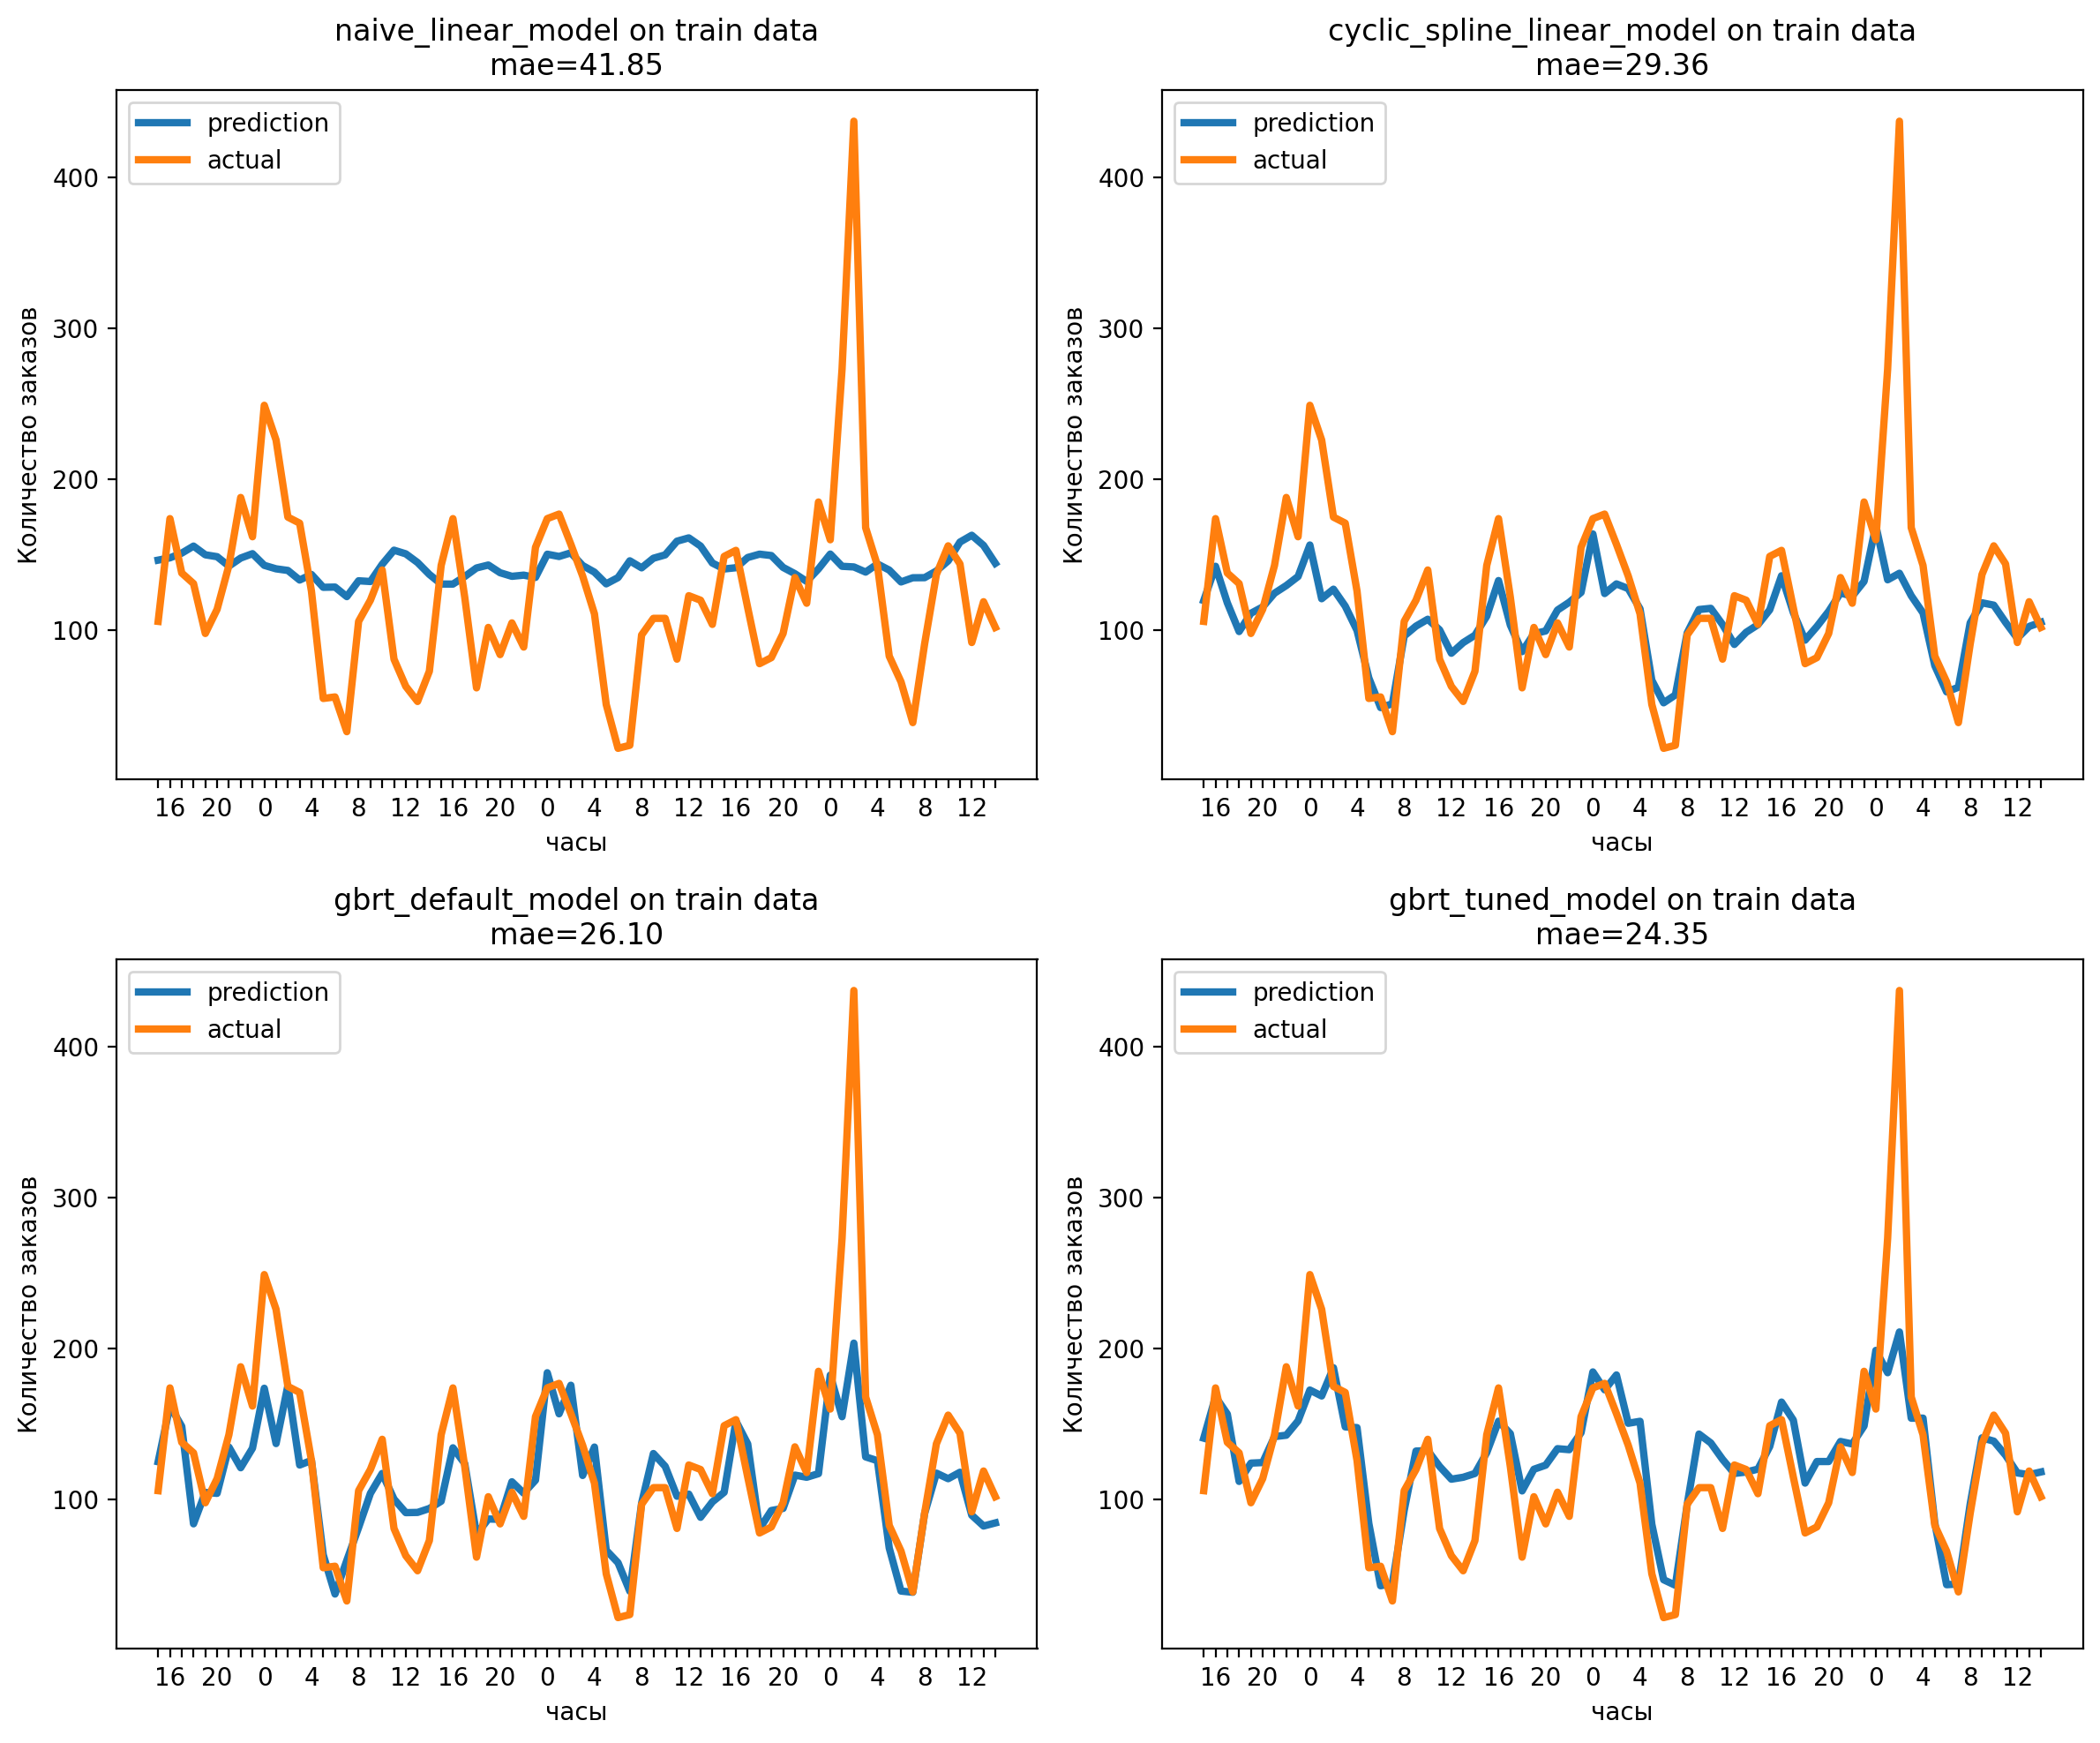

In [65]:
visualize_predictions(models=models,
                      model_names=model_names,
                      X = X_test[:term],
                      y = y_test[:term],
                      stage="Test")

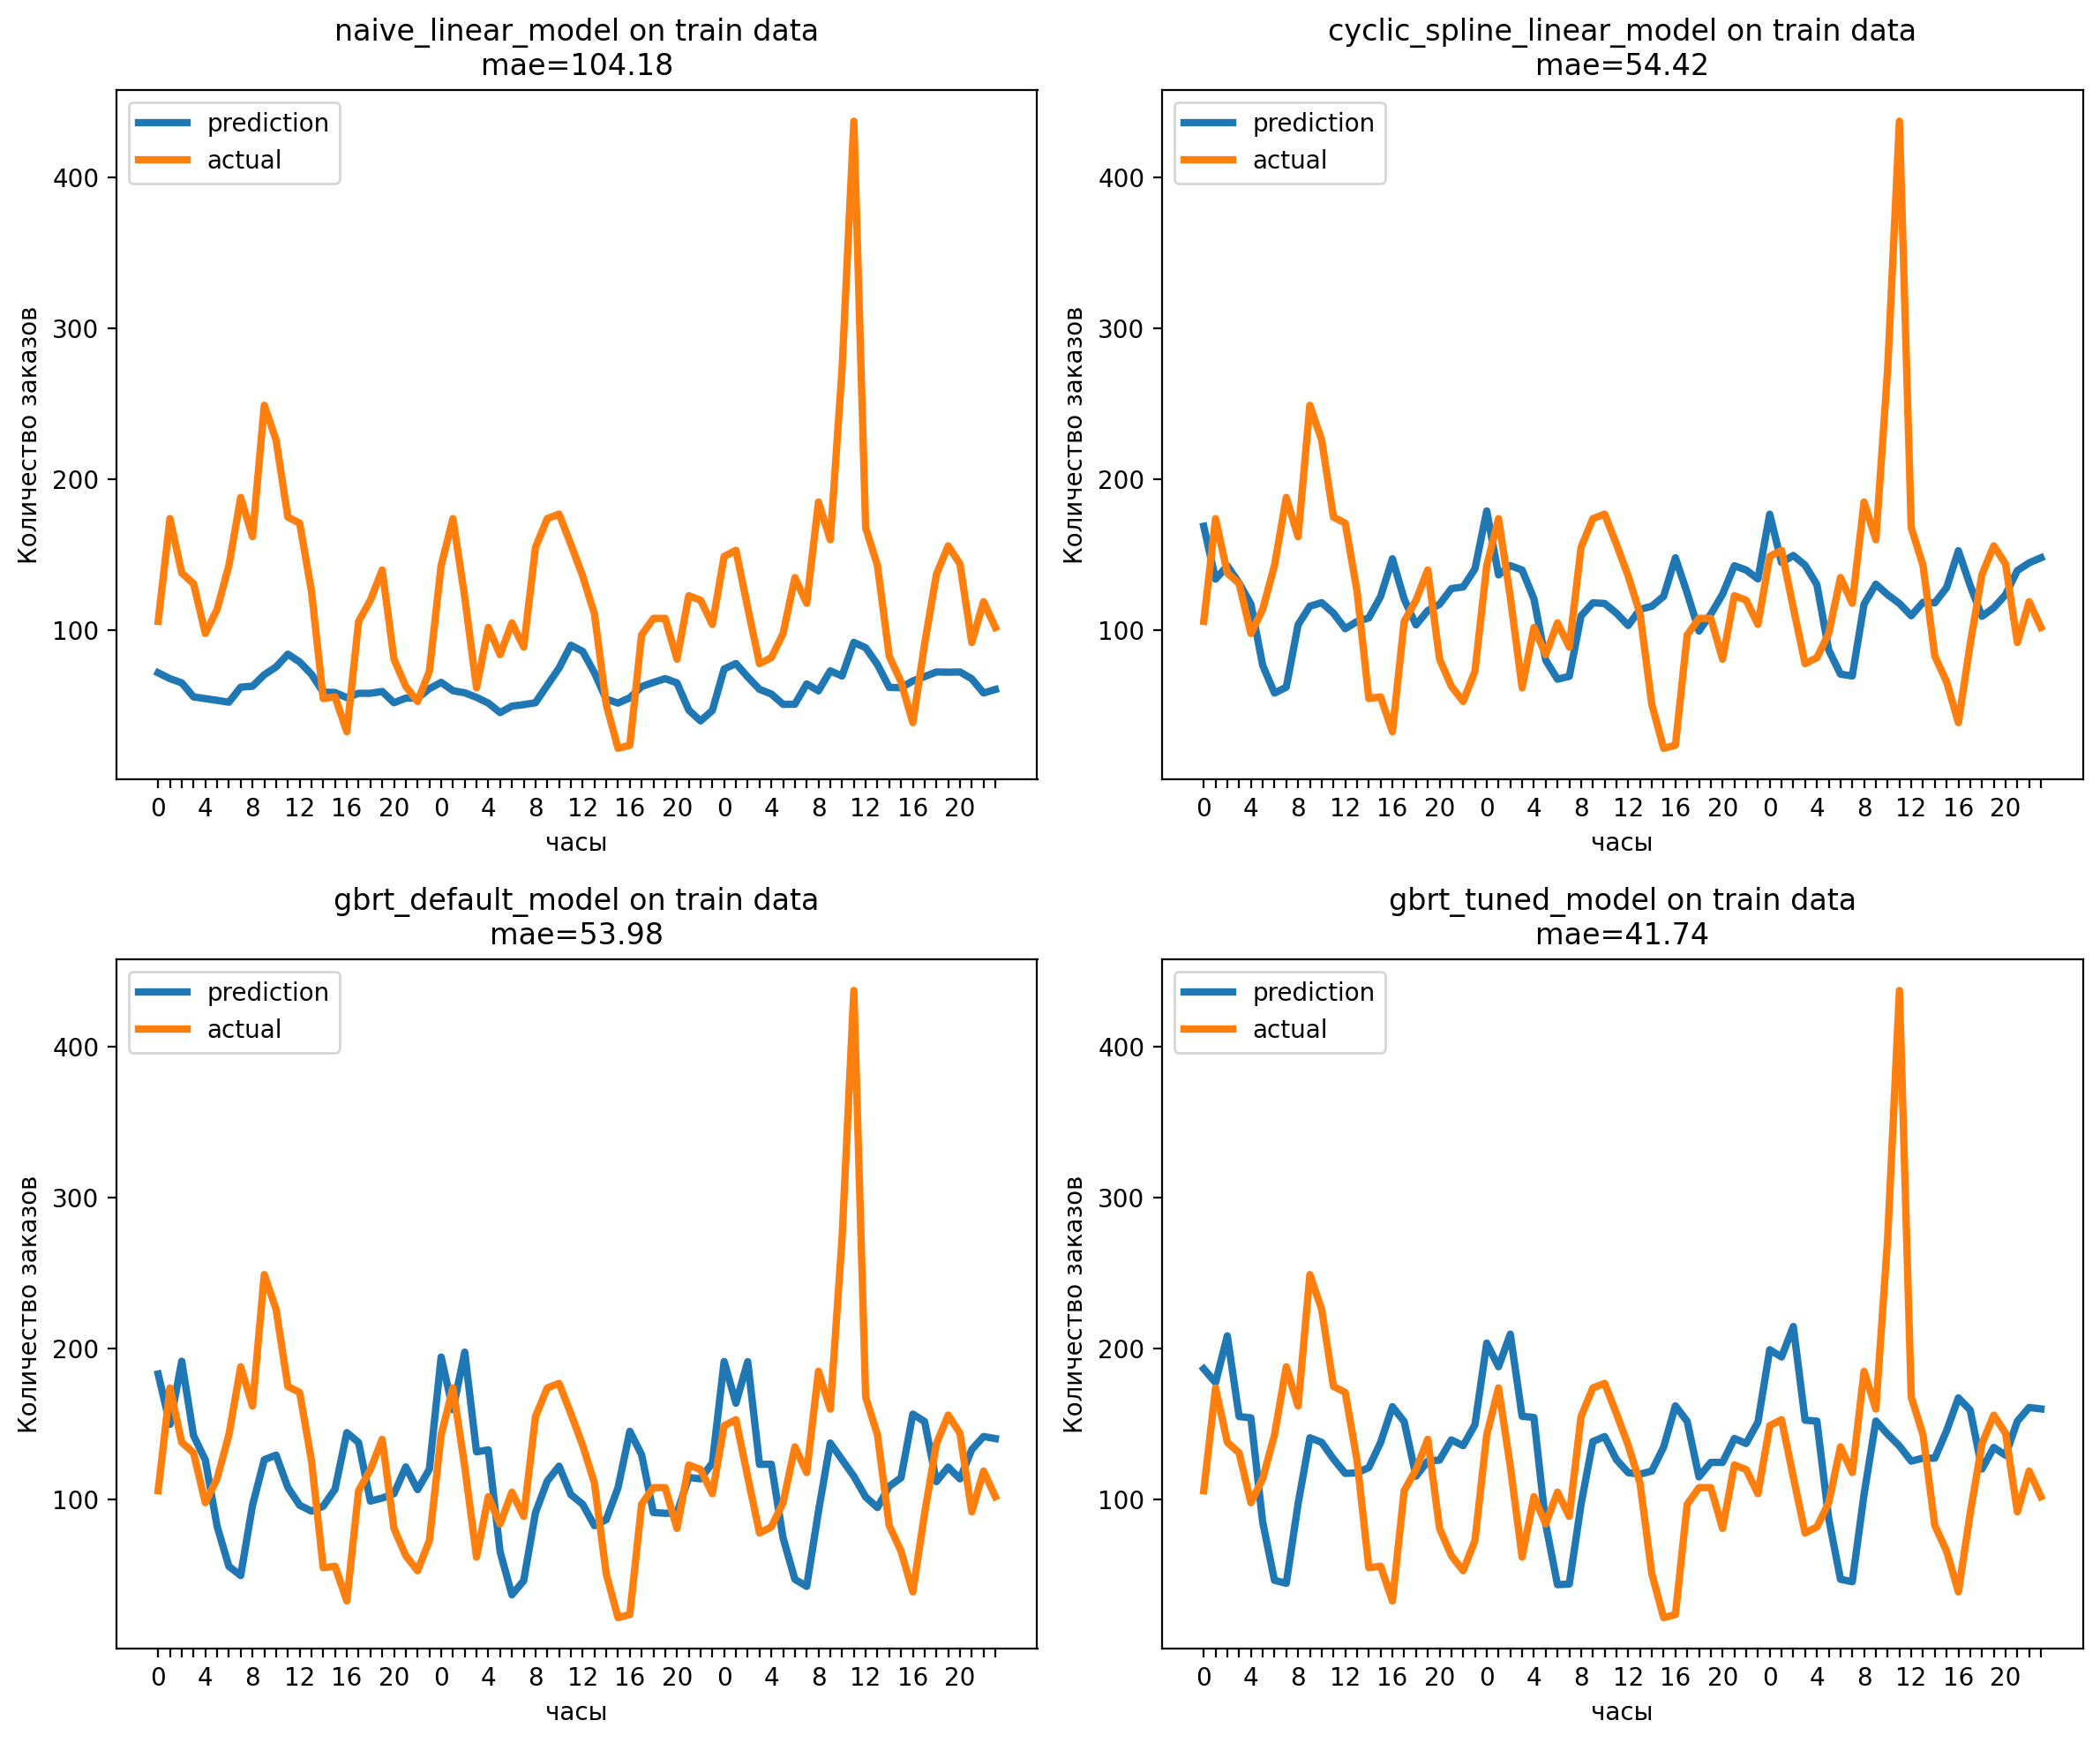

In [66]:
visualize_predictions(models=models,
                      model_names=model_names,
                      X = X_test[-term:],
                      y = y_test[-term:],
                      stage="Test")

## Вывод